# Programing exercise 5: ODE integrators

Due on Monday, 26.11.2018, 14.15h

### Total: 100 points

## The problem

We will again consider the collective Ising spin-model with a transverse field, as in programming exercise 4, which is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. We studied this model in detail on the previous exercise sheet using exact diagonalization. Now we want to test how different numerical integrators perform on this problem and use exact diagonalziation as a benchmark.

In [30]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse as sparse

%matplotlib inline

### Exact diagonalization code

Here is an example implemetation of the exact diagonalization which you can use and compare to.

Definitions for building the Hamiltonian

In [35]:
def buildSx(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz(N):
    return sparse.diags(np.arange(N+1)-N/2)

def buildH(N,ome):
    Sx = buildSx(N)
    Sz = buildSz(N)
    return -Sz @ Sz/N - ome*Sx 

Here we calculate the time evolution using exact diagonalization. This will be used to benchmark the performance of the numerical integrators.

In [36]:
dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)
tvecED = tvec

ome = 0.6

N = 20
dim = N+1
ini = np.eye(1,dim,0)[0]

Sz = buildSz(N)
Sx = buildSx(N)
Sz2 = Sz @ Sz
Hmat =buildH(N,ome)
    
observables = 1j*np.zeros((2,len(tvec)))

# ED solution
t1=time.time()
evals, evecs = LA.eigh(Hmat.toarray())
# calculate projections on eigenstates
iniProj = evecs.conj().T @ ini
for i in range(len(tvec)):
    Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    observables[0,i] = Szval
    observables[1,i] = Sxval
t2=time.time()
print('time for ED was '+str(t2-t1))


if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesED = observables.real


time for ED was 0.03697633743286133


### Exercise 1 (15 points)

Now we want to use different integrators to see how they perform. A code for testing the Euler method has already been implemeted for you. Run it and describe your observations. Play with the step size in the 1st part.

Intergration with Euler:

Integrate with a given step size to see accuracy.

time for Euler was 3.173835515975952


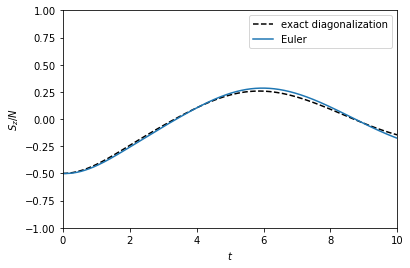

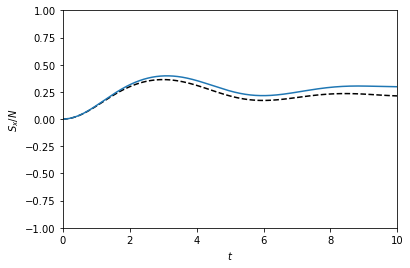

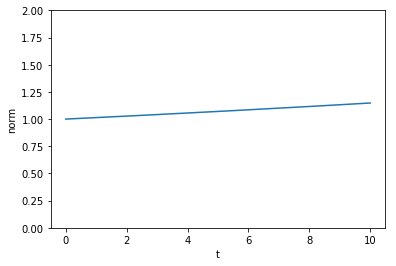

In [40]:
def Euler_step(y,Hmat,dt):
    return y - 1j*dt*Hmat @ y

dt = 0.001
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

tvecEuler = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm
# Integration steps:
for i in range(1,len(tvec)):
    Psit = Euler_step(Psit, Hmat, dt)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for Euler was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesEuler = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecEuler,observablesEuler[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecEuler[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','Euler'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecEuler,observablesEuler[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecEuler[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecEuler,observablesEuler[2])
plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

The cell below takes about 20s on my laptop to run.

In [41]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 11

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepize in range(n_red_step):
    
    step_sizes[istepize] = dt

    # initialize
    Psit=ini

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepize,0,0] = Szval - observablesED[0,0]
    deviations[istepize,1,0] = Sxval - observablesED[1,0]
    deviations[istepize,2,0] = norm - 1
    
    # propagation
    for i in range(1,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit = Euler_step(Psit, Hmat, dt)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepize,0,i] = Szval - observablesED[0,i]
        deviations[istepize,1,i] = Sxval - observablesED[1,i]
        deviations[istepize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


Some observables have non-zero imaginary parts!!


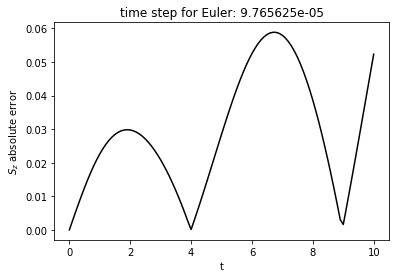

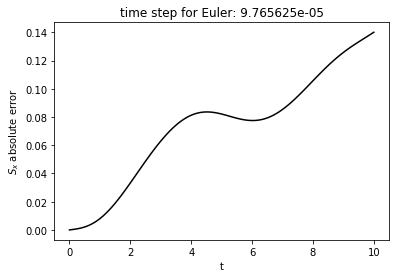

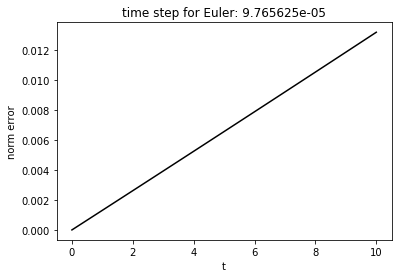

In [13]:
itstepsize = 10
plt.plot(tvecED,deviations[itstepsize,0],'k')
plt.title('time step for Euler: '+ str(step_sizes[istepize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[itstepsize,1],'k')
plt.title('time step for Euler: '+ str(step_sizes[istepize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[itstepsize,2],'k')
plt.title('time step for Euler: '+ str(step_sizes[istepize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

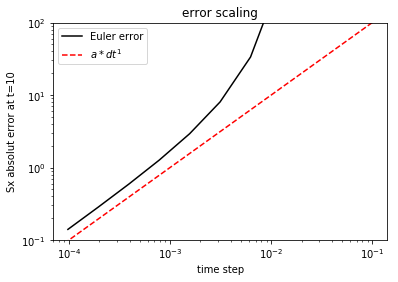

In [14]:
plt.loglog(step_sizes,deviations[:,1,-1],'k')
plt.loglog(step_sizes,10**3*step_sizes,'r--')
plt.title('error scaling')
plt.ylim([10**-1,10**2])
plt.legend(['Euler error','$a*dt^1$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

### Exercise 2 (40 points)

Do a corresponding anlysis for a second order Runge Kutta scheme (2nd order Taylor expansion of the evolution operator) and for the two-step method described in https://www5.in.tum.de/lehre/vorlesungen/wipro/ws16/folien/Askar_Explicit_Schroedinger.pdf
[equation (3.2)]. The two-step method matches the Taylor series to second order in dt, so we can use a RK2 step for initialization (to get $\psi_1$ from the initial wave function $\psi_0$).

For this case you can also go beyond $N=20$. Try at least $N=100$. With Euler, really tiny steps would be needed to prevent it from diverging in this case, but higher order integrators should do much better.

### Exercise 3 (25 points)

Now we want to use a numerical intergrator from the scipy.integrate module. For this I reccomend using the "ode" class which gives the best control of parameters and greatest choice of methods. The documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode

Try different integrators and options. Use a fixed particle number of N=100. Describe your observations. For me, the options that worked best are given as an example below. If you find something faster/mor stable, let me know!

These integrators all use adaptive stepsize internally, so we don't have to analyze the step size dependence of the accuracy. They should in principle always give accurate results or otherwise give a warning message that the specified accuracy goal could not be reached.

In [29]:
# use a scipy out-of-the-box integrator

from scipy.integrate import ode

def f(t, y, Hmat):
    return -1j*Hmat @ y # RHS of the SE

# how efficient is @ for sparse matrices? Is there a more efficient mehtod?
# improvement by using the Jacobian?

In [37]:
# initialize the integrator

y0, t0 = ini, 0

r = ode(f).set_integrator('zvode', method='adams', with_jacobian=False)
r.set_initial_value(y0, t0).set_f_params(Hmat)



### Exercise 4 (20 points)

Next, we want to check how their runtime for integrating our ODE scales with the number of spins N (or equivalently the Hilbert space dimension) and compare this to ED. Below is a code where you have to insert only your numerical integrator initialization and stepping.

For me, ED was still faster for up to N=1000. Try to find an integrator that beats by ED implementation!

Describe and interpret your observations.

[Optional] You can also try odeint (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) and/or solve_ivp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). These modules are less object oriented and have a restricted choice of integrators but are somewhat easier to use. 

All the documentation pages have a lot of useful information about the integrators and even links to the original publications in which they were introduced.

[Optional] Implement a Krylov subpace method. A good refernce on the details of this is https://www.sciencedirect.com/science/article/pii/S0010465598000836
The wikipadia page on the Arnoldi iteration even has a python sourrce code for constructing the Krylov vectors.

This method should work much better than the scipy integrators...

In [ ]:
# Compare ED to scipy.integrate.ode

dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)

ome = 0.6

# running it to N=2000 takes a few minutes and starts to use significant memeory (for testing, reduce this!)
Nvals = np.arange(200,2001,100) 

observables = 1j*np.zeros((4,len(tvec),len(Nvals))) # for storing the results for Sz and Sx for both methods
runtimes = np.zeros((3,len(Nvals))) # store time for H buildup, ED, and numerical integration

for iN in range(len(Nvals)):
    
    N = Nvals[iN]
    print(N)
    dim = N+1
    ini = np.eye(1,dim,0)[0]

    Sz = buildSz(N)
    Sx = buildSx(N)
    
    t1=time.time()
    Hmat =buildH(N,ome)
    t2=time.time()
    runtimes[0,iN] = t2-t1 # time for H matrix buildup, should be negligible

    # ED solution
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    # calculate time evolution
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i,iN] = Szval
        observables[1,i,iN] = Sxval
    t2=time.time()
    runtimes[1,iN] = t2-t1 # time for ED

    # integrator solution
    t1=time.time()
    t0 = 0

    #set up the integrator
    #### your code here ####
    
    i=0
    #initial values of observables
    Psit = ini
    i = 0
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[2,i,iN] = Szval
    observables[3,i,iN] = Sxval

    i+=1
    #loop over integrator steps
    #### your code here ####

    t2=time.time()
    runtimes[2,iN] = t2-t1 # time for integration
    
    
if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observables = observables.real

In [ ]:
# plotting observables to check that integration was converged and accurate
iN=-1
plt.plot(tvec,observables[0,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[2,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sz/N')
plt.show()

plt.plot(tvec,observables[1,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[3,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sx/N')
plt.show()

In [ ]:
# plotting N-dependence of runtimes
plt.loglog(Nvals,runtimes[0])
plt.loglog(Nvals,runtimes[1])
plt.loglog(Nvals,runtimes[2])
plt.loglog(Nvals,0.004*Nvals,'k--')
plt.loglog(Nvals,3*10**-6*Nvals**2,'k--')
plt.ylim([10**-1,2*10**1])
plt.xlim([2*10**2,2*10**3])
plt.show()